# Exercise set 7: Spatial data

In this exercise set you will be working with structuring and plotting spatial data. 
- Exercise 9.1: basic shapes
- Exercise 9.2: working with Geopandas and interpolation
- Exercise 9.3: interactive plotting with folium

We begin with loading the standard packages:


In [1]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import folium
import geopandas as gpd
import fiona
import shapely

%matplotlib inline

def convert_to_danish_crs(df):
    df.crs = 'EPSG:25832'

## Exercises

### Part 9.1: Working with spatial objects 

This exercise will serve as a brief tutorial on spatial data. We will learn how to make spatial shape and use their basic operations.

> **Ex. 9.1.1** Make a polygon which is square that has left,lower corner in 2,2 and right,upper in 5,5. Make a triangle passing through (0,0), (4,0) and (2,4). What do they look like? Store the two polygons respectively as `square` and `triangle`

> *Hint*: the submodule shapely.geometry has methods such as `Point`, `Polygon` and `Multipolygon`

In [2]:
from shapely.geometry import Polygon

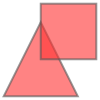

In [3]:
## Create square based on manual coordinate inputs
square_cords = np.array([(2,2),(2,5),(5,5),(5,2)])
square       = shapely.geometry.Polygon(square_cords)

## Create triangle based on manual coordinate inputs
triangle_cords = np.array([(0,0),(4,0),(2,4)])
triangle       = shapely.geometry.Polygon(triangle_cords)

## Show the square and triangle using multipolygon
shapely.geometry.MultiPolygon([triangle, square])

> **Ex. 6.1.2** Compute and show the spatial difference of square subtracted triangle, also show the hat is the union of `square` and `triangle`?

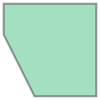

In [4]:
## The difference of square subtracted triangle
square.difference(triangle)

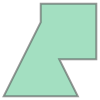

In [5]:
## The union set of square and triangle
square.union(triangle)

> **Ex. 6.1.3** Make a GeoSeries out of `square`, `triangle`. Plot the geoseries.

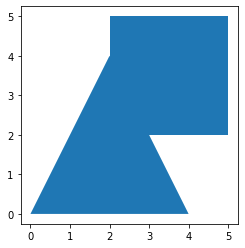

In [6]:
# Store square and triangle in a geopandas series and plot it
s = gpd.GeoSeries([square,triangle])
s.plot()

### Part 9.2: Working with house sale prices

Data on danish municipalities are available [here](https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson) from Open Knowledge Denmark.

#### Basic operations with Geopandas

> **Ex. 9.2.1** Load the municipalities data using `gpd.read_file()`, 
- What is the CRS of the dataframe - what projection does it correspond to? Turn the CRS into a meter based system.
- Which three munipalities have the largest area?

> Note: to find the entire area of a municipality which consists of multiple shapes (e.g. municipalities covering islands). you can use the `unary_union` method for GeoSeries.

In [7]:
## Answer 9.2.1.:
url         = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"
df_kommuner = gpd.read_file(url)

## Question regarding crs
raw_crs = df_kommuner.crs['init']
print(f"The ESPG of the raw kommune dataframe is {raw_crs}. It is degree based")

#convert_to_danish_crs(df_kommuner)
new_crs = df_kommuner.crs
print(f"The ESPG of the modified kommune dataframe is {new_crs}. It is meter based")


The ESPG of the raw kommune dataframe is epsg:4326. It is degree based
The ESPG of the modified kommune dataframe is {'init': 'epsg:4326'}. It is meter based


In [8]:
## Answer 9.2.1.: Question regarding area
df_kommuner = df_kommuner\
.assign(union_shape = lambda df:df.groupby('KOMNAVN')['geometry'].transform(shapely.ops.unary_union))\
.assign(union_area  = lambda df:[kom_area.area for kom_area in df.union_shape])\
.sort_values(by='union_area',ascending=False)

print("The 3 largest municipalities are:")
df_kommuner.loc[~df_kommuner.KOMNAVN.duplicated(),['KOMNAVN','union_area']].head(3)

The 3 largest municipalities are:


,KOMNAVN,union_area
207,Ringkøbing-Skjern,0.215362
98,Viborg,0.206978
228,Herning,0.191388


Use the script below to add regional information for municipalities. This code block assumes that your geodataframe is names `kommuner`.

In [9]:
## Answer 9.2.1.: Add municipality and region info
df_kommuner.columns = df_kommuner.columns.str.lower()
    
# information for municipality
kommune_info = pd.read_json('https://dawa.aws.dk/kommuner')\
                .pipe(lambda df: \
                        df.assign(komkode=df.kode.astype(str).str.zfill(4)))\
                .loc[:,['komkode','regionskode']]\
                

region_info = pd.read_json('https://dawa.aws.dk/regioner/')\
                .loc[:,['kode','navn']]\
                .add_prefix('regions')

df_kommuner = df_kommuner\
                .merge(kommune_info,how='left')\
                .merge(region_info,how='left')

> **Ex. 9.2.2** Make two boolean series as follows. 
> - first: row is True if corresponding the row shape is in the Capital Region or Sealand Region (i.e. `'Region Hovedstaden', 'Region Sjælland'`) 
> - second: row is True if the  the row geometry is ***not*** in Bornholm or nearby (i.e. `'Bornholm', 'Christiansø'`)

> Finally make a combined series which takes the value True if both holds, otherwise False and use this series to create a new geodataframe containing only mainland Sealand. 


> *Hint*: recall that we can check if a series elements are elements in a series using the `isin` method


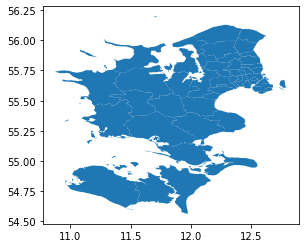

In [10]:
## Answer 9.2.2.:
df_kommuner = df_kommuner\
.assign(zealand = lambda df:df.regionsnavn.isin(['Region Hovedstaden','Region Sjælland']))\
.assign(not_bornholm = lambda df:~df.komnavn.isin(['Bornholm','Christiansø']))\
.assign(main_land_zealand = lambda df:df.zealand&df.not_bornholm)\

df_zealand = df_kommuner.loc[df_kommuner.main_land_zealand,:]
df_zealand.plot()

> **Ex. 9.2.3** Explain what is the CRS of the GeoDataFrame. How is distance measured using this coordinate system. Extract the extremum values (min,max) in all dimensions of the sealand geodataframe. That is identify the coordinates of the corners in the smallest square covering the entire island.

> *Hint*: extreme values, i.e. bounds, can be found using `.bounds` on a GeoDataFrame (also works on shapes, GeoSeries)

*ex 9.2.3 answer:* For the Danish case we use the EPSG 25832 standard. It is a 2-d coordinate system based on the metric system. This allows for easily calculations of distances using pythagoras and Euclidean distance formula. One may think of the coordinate system as a simple x-y diagram. Full explanation given here: Coordinate reference systems (CRS) are important because the geometric shapes in a GeoDataFrame are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates related to places on the Earth. A map projection (or a projected coordinate system) is a systematic transformation of the latitudes and longitudes into a plain surface where units are quite commonly represented as meters (instead of decimal degrees) from https://automating-gis-processes.github.io/2017/lessons/L2/projections.html

In [11]:
## Answer 9.2.3.:
min_x,min_y = df_zealand.geometry.bounds.min()[:2]
max_x,max_y = df_zealand.geometry.bounds.max()[2:]

print('Min values:')
print(df_zealand.geometry.bounds.min()[:2])
print('Max values:')
print(df_zealand.geometry.bounds.max()[2:])

Min values:
minx    10.868348
miny    54.559056
dtype: float64
Max values:
maxx    12.79876
maxy    56.19992
dtype: float64


#### Interpolation of house prices


In the following two exercises we aim to compute local spatial neighborhood measures of house prices in Sealand and around. We do this by making make a grid of Sealand houseprice data and using a neighborregressor to fill in data in squares that dont have any house sales. Thus the exercise will illustrate how to make a interpolation of data which is useful for feature engineering and get a good understanding of the data.

> **Ex. 9.2.4** Construct a 500mx500m grid for Sealand:
>- Make a grid of points 500m apart in horizontal and vertical directions that are within the extremum values of Sealand's shape. Each pair $(e,n)$ in this grid should be the coordinates of the lower left corner in a 500x500 square.
>- For each of these points construct a square polygon assuming that the point is the south west corner of the square. Do this using `cell_coords_to_polygons`.
>- Use `gpd.sjoin` to take the intersection of the municipalities in sealand and the square grid you have constructed. Plot the resulting geodataframe.
>
> *Hint 1:* Once you have created the grid the following function below may be useful for converting into a GeoDataFrame. You need to specify the column names for your x and y coordinates.
>
> *Hint 2:* We can select the points that intersect by using a spatial join between the house locations and municipalities.

In [12]:
dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}

def cell_coords_to_polygons(square_df, x='e', y='n', dist=500, crs=dk_crs):
    '''
    Convert coordinates to squares in a GeoDataFrame.
       
    Parameters
    ----------
    x : str
        Name of the horizontal coordinate (~longitude)            
    y : str
        Name of the vertical coordinate (~latitude)                        
    dist : int or float
        Size of polygons
    crs : dict
        Coordinate Reference System


    Returns
    ----------
    squares_gdf: geopandas.GeoDataFrame
        This table contains squares as geometry
        and the original data.
    '''
    
    def _to_square_polygon(row):
        '''
        This auxiliary function convert a square's lower,left 
        coordinates to a polygon. 
        
        Parameters
        ----------
        row : pandas.Series
            This is a DataFrame row.            
        
        Returns
        ----------
        poly: shapely.Polygon        
        
        '''
        
        square_coords = ((row[x], row[y]), 
                         (row[x]+dist, row[y]), 
                         (row[x]+dist, row[y]+dist), 
                         (row[x], row[y]+dist))
        
        poly = shapely.geometry.Polygon(square_coords)
        
        return poly
    
    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)
    
    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)
    
    return square_gdf

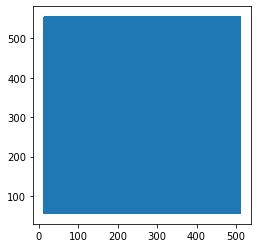

In [15]:
## Answer 9.2.4.:
x_values  = np.linspace(min_x,max_x,num=500)
y_values  = np.linspace(min_y,max_y,num=500)
df_square = pd.DataFrame({'e':x_values,'n':y_values})
df_square = cell_coords_to_polygons(df_square)
df_zealand.crs = dk_crs
df_square = gpd.sjoin(df_square,df_zealand)
df_square.plot()

> **Ex. 9.2.5**  Load the pre-structured data with house sales prices for Sealand. These data are available on Absalon as a .GeoJSON file. Construct a loop that for each year in the `sale_year` column 
> - extracts the house sales sold in this year, with a square meter price (`price_area`) between between 1000 and 120000. 
> - Selects the four columns `['sale_year', 'e', 'n', 'price_area']` and drops any rows with missing data. 
> - After preparing the data fit a `KNeighborsRegressor` with the coordinate columns `e` and `n` as features and the square-meter price as labels.
> - Computes predictions `preds` where `e`, `n` are taken from the square grid geodataframe you constructed above. Add 250 to each value to predict at the midpoint of the square!
> - creates a new column `p_{year}` in the square-grid geodataframe, containing `np.log10(preds)`
>
> Plot the grid data, coloring the grids by their predicted square meter price in 2012.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
price_gdf = gpd.read_file('houseprices.GeoJSON')

In [ ]:
# [Your answer here]